# Pneumonia detection Challenge form Kaggle

In [77]:
# Import necessary modules and libraries
import torch
from torch import nn
import matplotlib.pyplot as plt
import zipfile
from pathlib import Path

In [78]:
# Set up path to keep the dataset at
data_folder = Path('data')
data_file = data_folder/'pneumonia_dataset'


# We have a downloaded zip file of dataset. It will extract the zip file unless it is already extracted and the directory exists. 
if data_file.is_dir():
    print('Directory already exists. Skipping zip file extraction....')
else:
    with zipfile.ZipFile(data_folder/'rsna-pneumonia-detection-challenge.zip', 'r') as zip_ref:
        zip_ref.extractall(data_file)

Directory already exists. Skipping zip file extraction....


In [79]:
# Get and store all the path for the train and test data. Also `all_images_path` variable to store all the paths for all data (train and test data)

train_images_path = list(data_file.glob('stage_2_train_images/*.dcm'))
test_images_path = list(data_file.glob('stage_2_test_images/*.dcm'))
all_images_path = list(data_file.glob('*/*.dcm'))

In [80]:
print(f'Total number of Training Data: {len(train_images_path)} \nTotal number of Testing Data: {len(test_images_path)}\nTotal number of Data: {len(all_images_path)}')

Total number of Training Data: 26684 
Total number of Testing Data: 3000
Total number of Data: 29684


Text(0.5, 1.0, 'PatientID: 0004cfab-14fd-4e49-80ba-63a80b6bddd6')

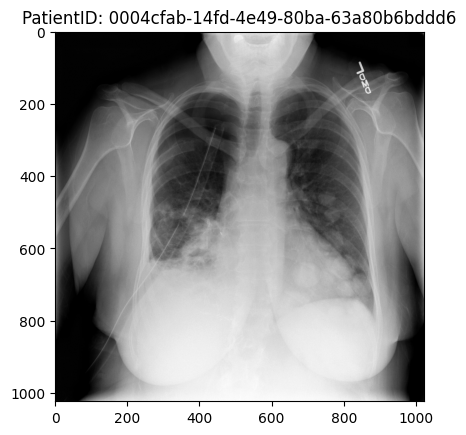

In [209]:
# Print out a sample data

import pydicom

image = pydicom.dcmread(train_images_path[0])
image_pixel = image.pixel_array
plt.imshow(image_pixel, cmap='grey')
plt.title(f'PatientID: {image.PatientID}')

In [82]:
# File path of the labels

label_file = data_file/'stage_2_train_labels.csv'
label_file

WindowsPath('data/pneumonia_dataset/stage_2_train_labels.csv')

## The order of data and the labels do not match. So work to make them in correct order so the index of the data correspond to the index of the label

## Working with label document of test images which is a CSV file with `pandas`

In [ ]:
### storing all the labels form the label document into the 'df_train_label_file'
### then we go through all of train data and store the patientID form all of the data into the 'train_patientID_list' list

In [88]:
import pandas as pd

# read the label csv file into the 'df_label_file' variable
df_label_file = pd.read_csv(label_file)
display(df_label_file[:5])


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [90]:
# Get the patient Id from the test data and put them in a list 
# Later we will use this list as a reference to search for the labels(with patient ID) index and then reorder them in the shape order of the test data

train_patientId = []

for i in range(len(train_images_path)):

    imageId = pydicom.dcmread(train_images_path[i]).PatientID

    train_patientId.append(imageId)


In [ ]:
# # We store this list of patient Id form test data into a CSV file
# df_train_imageId = pd.DataFrame(train_patientId, columns=['patientId'])
# display(df_train_imageId[:5])
# df_train_imageId.to_csv('test.csv', index=False)
# df_train_imageId

In [106]:
train_patientId

['0004cfab-14fd-4e49-80ba-63a80b6bddd6',
 '000924cf-0f8d-42bd-9158-1af53881a557',
 '000db696-cf54-4385-b10b-6b16fbb3f985',
 '000fe35a-2649-43d4-b027-e67796d412e0',
 '001031d9-f904-4a23-b3e5-2c088acd19c6',
 '0010f549-b242-4e94-87a8-57d79de215fc',
 '001916b8-3d30-4935-a5d1-8eaddb1646cd',
 '0022073f-cec8-42ec-ab5f-bc2314649235',
 '0022995a-45eb-4cfa-9a59-cd15f5196c64',
 '0025d2de-bd78-4d36-9f72-e15a5e22ca82',
 '00293de0-a530-41dc-9621-0b3def01d06d',
 '002c591d-df62-4e34-8eda-838c664430a9',
 '002cb550-2e31-42f1-a29d-fbc279977e71',
 '00313ee0-9eaa-42f4-b0ab-c148ed3241cd',
 '00322d4d-1c29-4943-afc9-b6754be640eb',
 '003d8fa0-6bf1-40ed-b54c-ac657f8495c5',
 '00436515-870c-4b36-a041-de91049b9ab4',
 '0049f7b2-229b-4a46-91a3-0e321a3ca80a',
 '0053ee32-1e03-4dc2-a103-f46ad0448787',
 '00569f44-917d-4c86-a842-81832af98c30',
 '005f5517-ab76-4b0d-8a26-f808d97171c4',
 '0067d70b-0e6d-41ff-a9b8-8edf6d5e25e4',
 '006cec2e-6ce2-4549-bffa-eadfcd1e9970',
 '006e75c8-1fd9-4a5a-99e7-285addebed55',
 '00704310-78a8-

In [123]:
## Arrange the label in the same order as the data order by comapring the ID

reordered_labels = []

for i in range(len(train_images_path)):
    
    patientId = train_patientId[i]
    print(patientId) 
    

    # index values can be list with multiple values if there are multiple pneumonia spots in the single data
    index = df_label_file[df_label_file['patientId'] == patientId].index
    

    print(index,'\n')
    # print(index.item())

    # break

    if i == 3:
        break


0004cfab-14fd-4e49-80ba-63a80b6bddd6
Index([0], dtype='int64') 

000924cf-0f8d-42bd-9158-1af53881a557
Index([28989], dtype='int64') 

000db696-cf54-4385-b10b-6b16fbb3f985
Index([28990, 28991], dtype='int64') 

000fe35a-2649-43d4-b027-e67796d412e0
Index([28992, 28993], dtype='int64') 



In [210]:
rows = 3
columns = 6

import random
# Sample random int from a index equalling the lenght of train data 
rand_int_list = random.sample(range(len(train_images_path)), k=rows*columns)

# Create a dict for label 0 and 1 which correspond to Pneumonia Absent and Present
labels_dict = {0: 'Absent',
               1: 'Present'}

labels_dict[0], labels_dict[1]

('Absent', 'Present')

In [211]:
# The follwing label is incorrect because the data patientId and label patientId are not in order

# get all the labels from the label file and store it in the 'all_labels_list' list

labels_o_list = []

import csv

with open(label_file) as csvfile:
    csv_reader = csv.reader(csvfile)

    # Calling this will also store the header of the CSV file in the `header` variable and the next time we call `csv_reader` we will have directly access to the data values
    header = next(csv_reader)
    print(header)

    label_index = header.index('Target')

    for row in csv_reader:
    
        labels = int(row[label_index])
        labels_o_list.append(labels)

['patientId', 'x', 'y', 'width', 'height', 'Target']


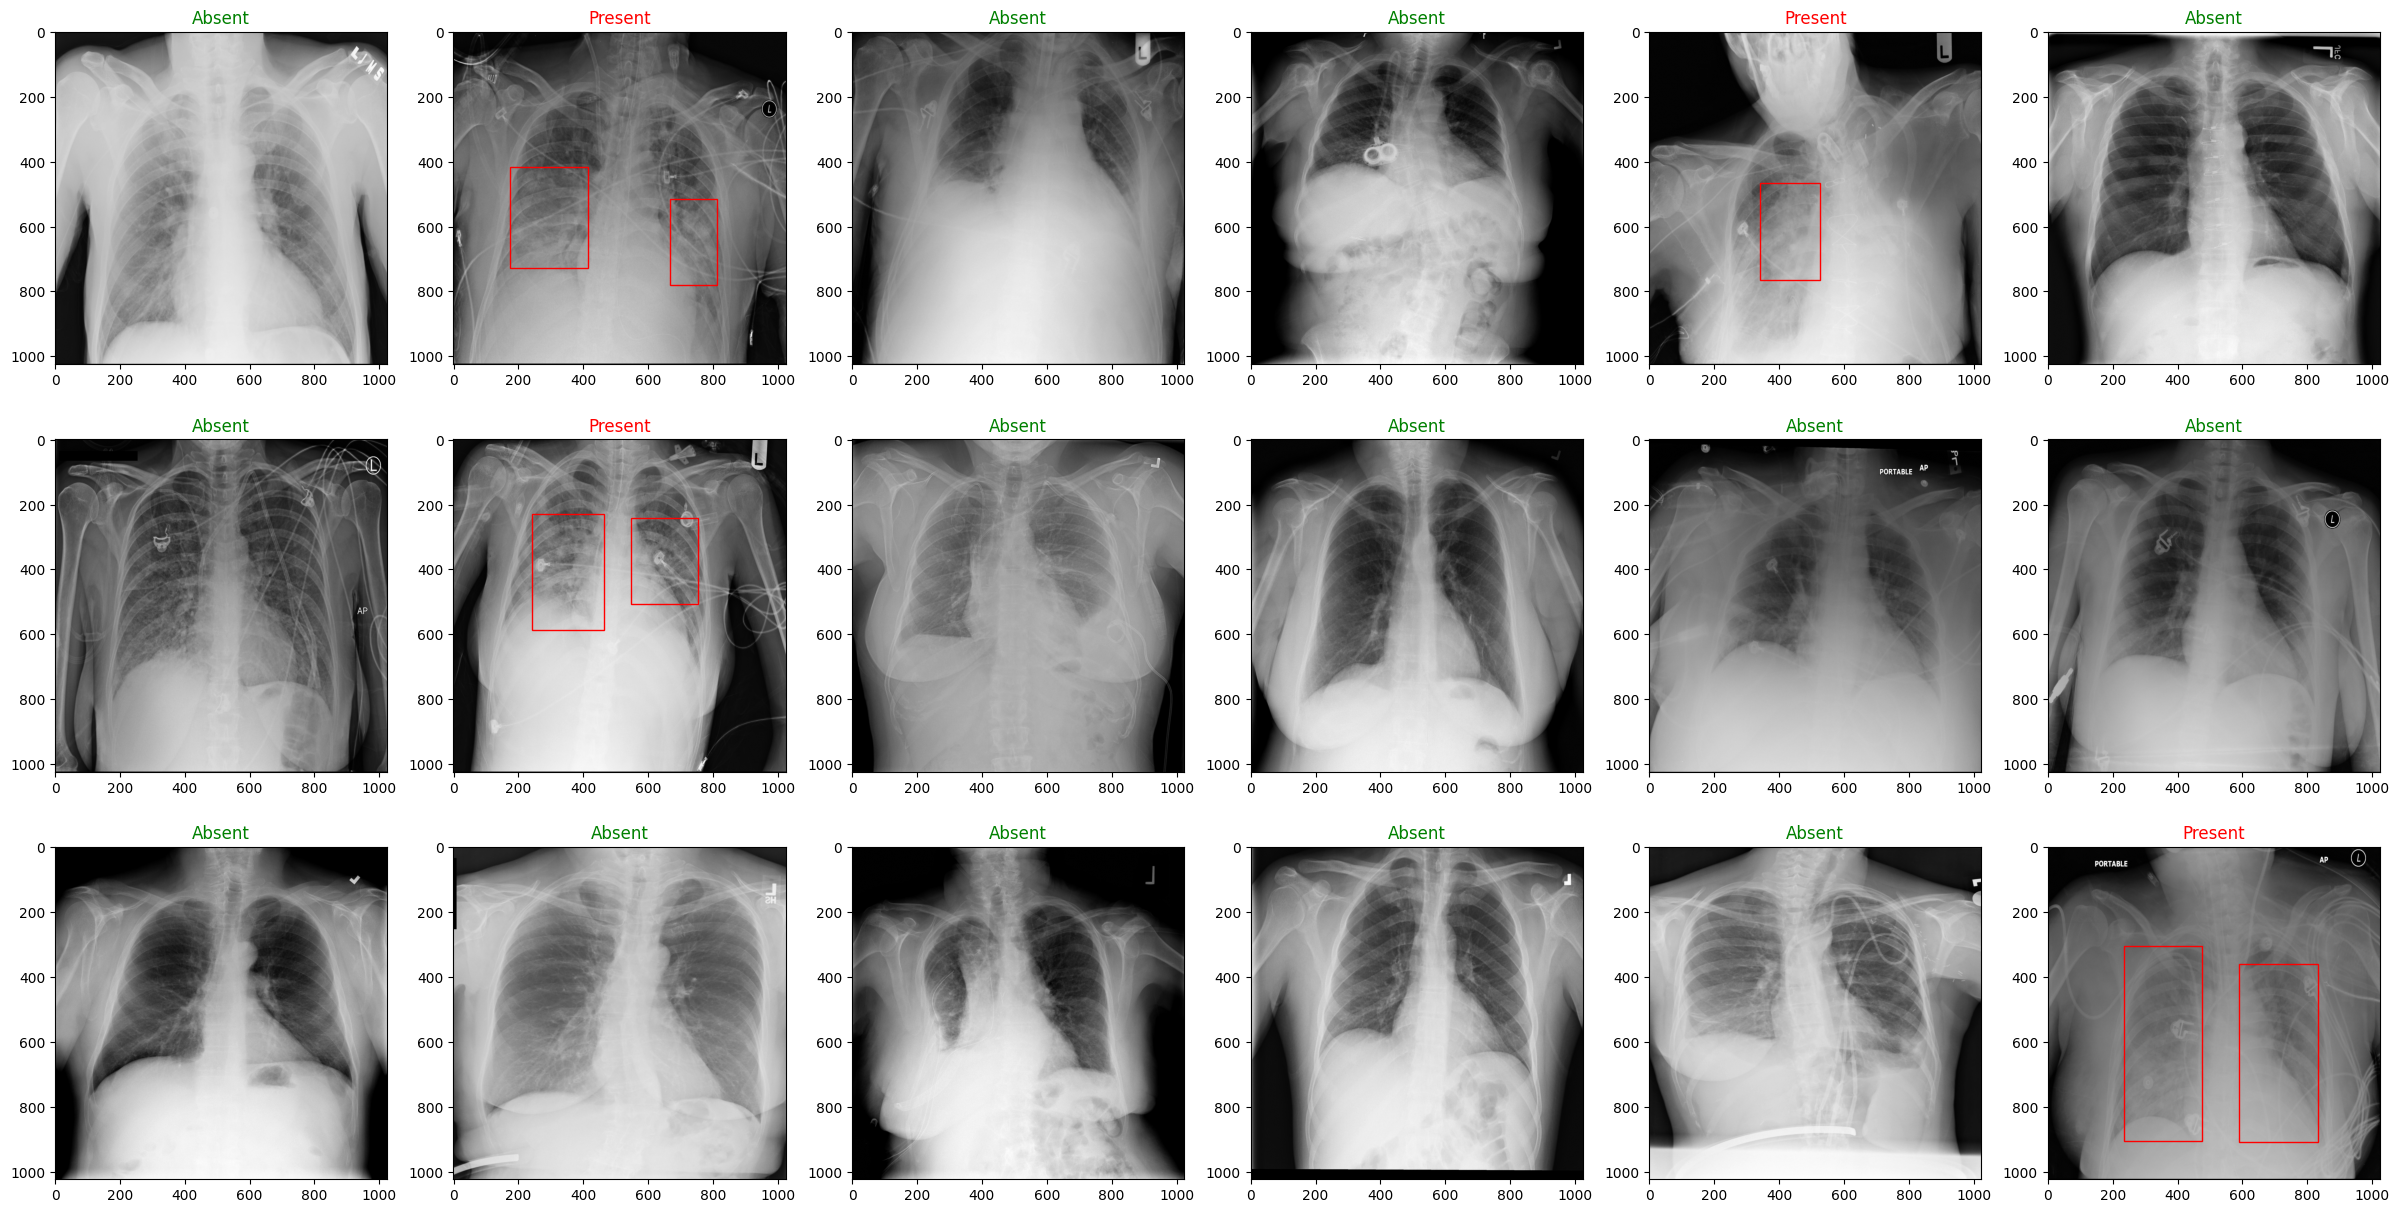

In [ ]:
# Print out the randomly sampled images in a subplot with a box to determine the pneumonia spots

from matplotlib.patches import Rectangle

plt.figure(figsize=(30, 15))

for i in range(len(rand_int_list)):
    plt.subplot(rows, columns, i+1)

    random_int = rand_int_list[i]
    
    # get the random images and their pixel values
    image_path = train_images_path[random_int]
    image = pydicom.dcmread(image_path)
    image_pixel = image.pixel_array

    # get the patient Id of the images
    Id = image.PatientID

    # search for the labels of those patientId in the label file
    label_data = df_label_file[df_label_file['patientId'] == Id]

    # Loop for the case that the image has multiple labels representing multiple spots(multiple coordinate data of spots) of pneumonia spots
    for index in range(len(label_data)):
        all_data = label_data.iloc[index]

        # If the label of the image has pneumonia we use the (coordinated data) data from the label document to draw a box at where the pneumonia spot is at
        if all_data['Target'].item() == 1:
            x, y, width, height = all_data['x'].item(), all_data['y'].item(), all_data['width'].item(), all_data['height'].item()
            rect = Rectangle([x, y], width=width, height=height, facecolor='none', edgecolor='red')
            # print(x, y, width, height)
            plt.gca().add_patch(rect)


    plt.imshow(image_pixel, cmap='gray')
    # image_label = labels_o_list[random_int]

    # We do .iloc[0] cuz, if the label is single it will just index to that single label but if it has multiple label then it will go to the first label, and see its target which is same as its other label. 
    # Also if we try to get the 'Target' value of the label data when it has multiple label then we will get error. so this indexing is important.
    image_label = label_data.iloc[0]['Target']


    color = 'green' if image_label == 0 else 'red'

    plt.title(labels_dict[image_label], color=color)

In [257]:
list(labels_dict.keys()), labels_dict

([0, 1], {0: 'Absent', 1: 'Present'})

In [ ]:
## Create a custom dataset class


from torch.utils.data import Dataset

class CustomDataset(Dataset):

    # Initalize our custom dataset
    def __init__(self, data_path, transform, labels_dict):
        super().__init__()
         
        # Create class attributes
        self.file_path = list(Path(data_path).glob('*.dcm'))

        self.transform = transform

        self.classes = list(labels_dict.keys())
        self.classes_to_idx = labels_dict

    # Create a funtion to load image
    def load_image():
        pass
    
    pass


x = CustomDataset
x

__main__.CustomDataset

In [254]:


z = list(labels_dict.keys())
z[0]


0

In [225]:
train_dir = Path(data_file/'stage_2_train_images')
test_dir = Path(data_file/'stage_2_test_images')

train_dir, test_dir

(WindowsPath('data/pneumonia_dataset/stage_2_train_images'),
 WindowsPath('data/pneumonia_dataset/stage_2_test_images'))